### CNN Model:
- CNN (Convolutional Neural Network): Extracts spatial patterns from time-series sensor data.
- Used for disease classification

#### Workflow
- Load each task data
- split data to train and test set
- Normalize each set to prevent data leakage
- Reshape data sets
- train model with each task data


In [93]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
import keras # used to build CNN

In [94]:
# Load extracted features
df = pd.read_csv("../processed-data/cleaned-parkinsons-data.csv")


In [95]:
# Encode categorical variables
label_encoders = {}
for col in ['Task']:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Map DeviceLocation to numerical values
df["Device_Location"] = df["Device_Location"].map({"RightWrist": 0, "LeftWrist": 1})
# Define input features (past movement + metadata) and target (future movement)
features = ['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'Task', 'Time', 'Device_Location', 'Age_At_Diagnosis', 'Gender', 'Handedness']
target = ['Condition']  # Predict future movement



In [96]:



# Sort data by Patient ID and time
df = df.sort_values(by=['Patient_id'])

# Ensure strict sequential train-test split (no shuffle and preserving order)


train_data_list = []
test_data_list = []

# Split and normalize per patient to prevent data leakage
scaler = MinMaxScaler()

for patient_id, patient_df in df.groupby('Patient_id'):
    split_index = round(int(len(patient_df) * 0.8))  # 80% train, 20% test
    
    train_patient = patient_df.iloc[:split_index]
    test_patient = patient_df.iloc[split_index:]

    # Normalize per patient
    train_patient[features] = scaler.fit_transform(train_patient[features])
    test_patient[features] = scaler.transform(test_patient[features])

    train_data_list.append(train_patient)
    test_data_list.append(test_patient)

# Combine segmented data
train_data = pd.concat(train_data_list)
test_data = pd.concat(test_data_list)

# Function to create sequences for each patient's data
sequence_length = 10
def create_sequences(data, sequence_length=sequence_length):
    sequences = []
    labels = []
    
    for patient_id, patient_df in data.groupby('Patient_id'):
        patient_data = patient_df.reset_index(drop=True)  # Reset index for sequential slicing
        
        for i in range(len(patient_data) - sequence_length):
            seq = patient_data.iloc[i:i+sequence_length][features].values
            label = patient_data.iloc[i+sequence_length][target].values  # Predict next step
            sequences.append(seq)
            labels.append(label)
    
    return np.array(sequences), np.array(labels)

# Create sequences
X_train, y_train = create_sequences(train_data, sequence_length=sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length=sequence_length)





In [97]:
# Define LSTM time-series model for movement variability prediction
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])), # input_shape=(time_steps, num_features) # input_shape=(num_features, num_channels) 1D CNN
    BatchNormalization(), # Normalize data
    MaxPooling1D(pool_size=2), # Pooling layer
    Dropout(0.5), # Dropout layer to prevent overfitting

    Conv1D(filters=32, kernel_size=3, activation='relu'), # 2nd Conv1D layer 
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),

    Flatten(), # Flatten layer to convert 2D to 1D 
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(32, activation='relu'), # Dense layer
    Dropout(0.5),

    Dense(1, activation='sigmoid')  #  6 Multi-class classification # use sigmoid for binary classification
])

In [98]:
# Compile model with optimized settings with sdg optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.(learning_rate=0.0005), 
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])

# Train model with early stopping and learning rate reduction


history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7368 - loss: 0.6212 - val_accuracy: 0.7843 - val_loss: 0.5115
Epoch 2/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7835 - loss: 0.5240 - val_accuracy: 0.7843 - val_loss: 0.4895
Epoch 3/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7846 - loss: 0.5024 - val_accuracy: 0.7871 - val_loss: 0.4651
Epoch 4/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7873 - loss: 0.4880 - val_accuracy: 0.7961 - val_loss: 0.4543
Epoch 5/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7900 - loss: 0.4795 - val_accuracy: 0.7984 - val_loss: 0.4512
Epoch 6/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7956 - loss: 0.4689 - val_accuracy: 0.8031 - val_loss: 0.4541
Epoch 7/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7960 - loss: 0.4672 - val_accuracy: 0.8083 - val_loss: 0.4454
Epoch 8/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8001 - loss: 0.4584 - 

In [99]:
# save Model
model.save("../models/cnn_lstm_model2.keras")
print("Model training complete. Saved as 'cnn_lstm_model2.keras'.")

# evaluate Model performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Model training complete. Saved as 'cnn_lstm_model2.keras'.
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - accuracy: 0.8332 - loss: 0.4040
Test Accuracy: 82.62%


### Plot Training Accuracy & Loss Curves

In [100]:
 # Extract loss & accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

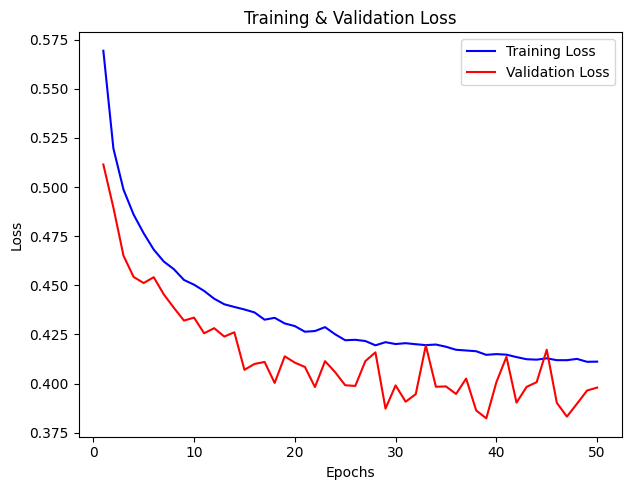

In [101]:
# Plot Loss Curve
plt.figure(figsize=(12, 5))
    
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()


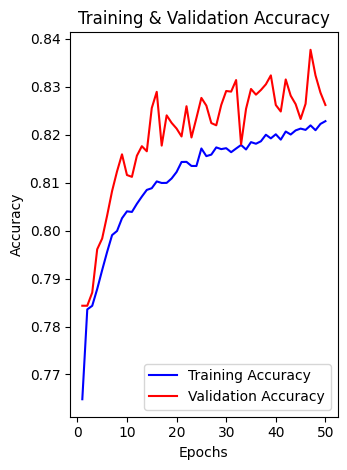

In [102]:
# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [103]:
y_pred_prob = model.predict(X_test)  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary predictions

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Healthy", "Parkinson's"]))

738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
[[ 1292  3801]
 [  303 18220]]
              precision    recall  f1-score   support

     Healthy       0.81      0.25      0.39      5093
 Parkinson's       0.83      0.98      0.90     18523

    accuracy                           0.83     23616
   macro avg       0.82      0.62      0.64     23616
weighted avg       0.82      0.83      0.79     23616



738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step


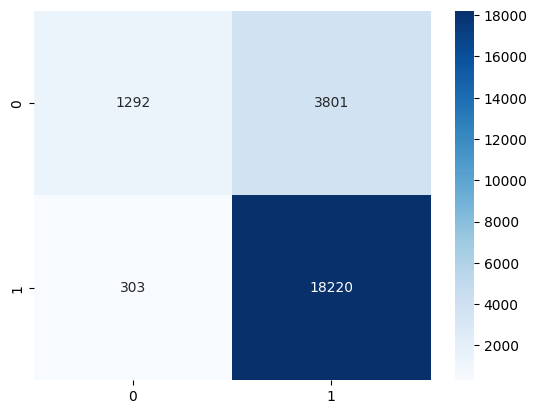

              precision    recall  f1-score   support

     Healthy       0.81      0.25      0.39      5093
 Parkinson's       0.83      0.98      0.90     18523

    accuracy                           0.83     23616
   macro avg       0.82      0.62      0.64     23616
weighted avg       0.82      0.83      0.79     23616



In [104]:
# Confusion Matrix
y_pred = (model.predict([X_test]) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=["Healthy", "Parkinson's"]))